# Acceptance calculation in bins of p<sub>T</sub> and eta.

In [1]:
import time
import os
import numba

from coffea.nanoevents import BaseSchema
 
import awkward as ak
import numpy as np
from coffea import processor, hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import mplhep
import matplotlib.pyplot as plt
plt.style.use(mplhep.style.CMS)

In [2]:
muon_cols = ['Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_eta', 'Muon_isGlobal', 'Muon_mass',
             'Muon_phi', 'Muon_pt', 'Muon_ptErr', 'Muon_softId', 'Muon_vtxIdx', 'Muon_vtxFlag', 'Muon_simIdx']

dimu_cols = ['Dimu_pt', 'Dimu_eta', 'Dimu_phi', 'Dimu_rap', 'Dimu_mass', 'Dimu_charge', 'Dimu_vtxIdx', 'Dimu_chi2', 'Dimu_dl',
             'Dimu_dlErr', 'Dimu_dlSig', 'Dimu_cosphi', 'Dimu_x', 'Dimu_y', 'Dimu_z', 'Dimu_t1muIdx', 'Dimu_t2muIdx',]

gen_part_cols = ['GenPart_eta', 'GenPart_genPartIdxMother', 'GenPart_mass', 'GenPart_pdgId', "GenPart_phi", "GenPart_pt", 'GenPart_status',
                'GenPart_Id', 'GenPart_parpdgId', 'GenPart_sparpdgId', 'GenPart_numberOfDaughters', 'GenPart_nstchgdaug', 'GenPart_vx', 
                'GenPart_vy', 'GenPart_vz', 'GenPart_mvx', 'GenPart_mvy', 'GenPart_mvz', 'GenPart_recIdx']

dstar_cols = ['Dstar_pt', 'Dstar_eta', 'Dstar_phi', 'Dstar_rap', 'Dstar_deltam', 'Dstar_deltamr', 'Dstar_vtxIdx', 'Dstar_hasMuon',
              'Dstar_D0pt', 'Dstar_D0eta', 'Dstar_D0phi', 'Dstar_D0mass', 'Dstar_D0chi2', 'Dstar_D0dl', 'Dstar_D0dlErr',
              'Dstar_D0dlSig', 'Dstar_D0cosphi', 'Dstar_D0x', 'Dstar_D0y', 'Dstar_D0z',
              'Dstar_Kpt', 'Dstar_Keta', 'Dstar_Kphi', 'Dstar_KvtxIdx', 'Dstar_Kchindof', 'Dstar_KnValid', 'Dstar_KnPix', 'Dstar_Kdxy',
              'Dstar_Kdz', 'Dstar_Kchg',
              'Dstar_pipt', 'Dstar_pieta', 'Dstar_piphi', 'Dstar_pivtxIdx', 'Dstar_pichindof', 'Dstar_pinValid', 'Dstar_pinPix',
              'Dstar_pidxy', 'Dstar_pidz', 'Dstar_pichg',
              'Dstar_pispt', 'Dstar_piseta', 'Dstar_pisphi', 'Dstar_pisvtxIdx', 'Dstar_pischindof', 'Dstar_pisnValid', 'Dstar_pisnPix',
              'Dstar_pisdxy', 'Dstar_pisdz', 'Dstar_simIdx']

D0_PDG_MASS = 1.864

def get_vars_dict(events, col_list):
    dict = {}
    col = ''
    for c in col_list:
        if c.startswith('Muon'):
            col = c[5:]
        elif c.startswith('Dimu'):
            col = c[4:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('D0'):
            col = c[2:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('Dstar'):
            col = c[5:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('PVtx'):
            col = c[5:]
        elif c.startswith("GenPart"):
            col = c[8:]
        else:
            Exception('Not good!')

        if col == 'x' or col == 'y' or col == 'z':
            col = 'vtx_' + col

        if len(events[c]) == 0:
            dict[col] = np.array([])
        else:
            dict[col] = events[c]
    return dict

In [3]:
import re

files = []
with os.scandir("/eos/user/m/mabarros/Monte_Carlo/dstar_gun/0000") as it:
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            files.append(file.path)

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
            
files.sort(key=natural_keys)

In [4]:
def create_plot1d(hist1d, log=False, density=False, ax=None):
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })
    fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
    }
    
    ax = hist.plot1d(hist1d, ax=ax, fill_opts=fill_opts, density=density)
    
    if log:
        ax.set_yscale('log')
        ax.set_ylim(1, None)
    else:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)
    
    axis = hist1d.axes()[0]
    centers = axis.centers()
    values = np.where(hist1d.values().get(()) < 0, 0, hist1d.values().get(()))
    
    # compute mean and std:
    mean = np.sum(values*centers)/np.sum(values)
    std = np.sqrt(np.sum(values*((centers - mean)**2))/np.sum(values))
    
    annotation = TextArea(f"Total: {np.sum(values):.2e}" \
                    + "\n" + f"Mean: {mean:.2e}" \
                    + "\n" + f"Std: {std:.2e}", textprops=dict(size=14))
    
    at = AnchoredOffsetbox('upper right', child=annotation)
    at.patch.set_facecolor('None')
    #ax.add_artist(at)
    
    ax.legend().remove()
    
    return ax

In [5]:
class AcceptTestProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            'n_reco_dimu': processor.value_accumulator(int),
            'Jpsi_reco_pt' : hist.Hist("Events", hist.Bin("pt", "$p_{T,\mu^+\mu^-}$ [GeV]", 10, 0, 100)),
            'Jpsi_reco_eta' : hist.Hist("Events", hist.Bin("eta", "$\eta_{\mu^+\mu^-}$", 10, -2.5, 2.5)),
            'Jpsi_reco_phi' : hist.Hist("Events", hist.Bin("phi", "$\phi_{\mu^+\mu^-}$", 70, -3.5, 3.5)),
                                        
            'Jpsi_gen_pt' : hist.Hist("Events", hist.Bin("pt", "$p_{T,\mu^+\mu^-}$ [GeV]", 10, 0, 100)),
            'Jpsi_gen_eta' : hist.Hist("Events", hist.Bin("eta", "$\eta_{\mu^+\mu^-}$", 10, -2.5, 2.5)),
            'Jpsi_gen_phi' : hist.Hist("Events", hist.Bin("phi", "$\phi_{\mu^+\mu^-}$", 70, -3.5, 3.5)),
            
                                       
            'Jpsi_reco_pt_eta': hist.Hist("Events", 
                                          hist.Bin("pt", "$p_{T,\mu^+\mu^-}$ [GeV]", 10, 0, 100),
                                          hist.Bin("eta", "$\eta_{\mu^+\mu^-}$", 10, -2.5, 2.5)),    
            'Jpsi_gen_pt_eta': hist.Hist("Events", 
                                          hist.Bin("pt", "$p_{T,\mu^+\mu^-}$ [GeV]", 10, 0, 100),
                                          hist.Bin("eta", "$\eta_{\mu^+\mu^-}$", 10, -2.5, 2.5)),  
            
             'Dstar_reco_pt' : hist.Hist("Events", hist.Bin("pt", "$p_{T,D*}$ [GeV]", 10, 0, 100)),
             'Dstar_reco_eta' : hist.Hist("Events", hist.Bin("eta", "$\eta_{D*}$", 10, -2.5, 2.5)),
             'Dstar_reco_phi' : hist.Hist("Events", hist.Bin("phi", "$\phi_{D*}$", 70, -3.5, 3.5)),
                                        
             'Dstar_gen_pt' : hist.Hist("Events", hist.Bin("pt", "$p_{T,D*}$ [GeV]", 10, 0, 100)),
             'Dstar_gen_eta' : hist.Hist("Events", hist.Bin("eta", "$\eta_{D*}$", 10, -2.5, 2.5)),
             'Dstar_gen_phi' : hist.Hist("Events", hist.Bin("phi", "$\phi_{D*}$", 70, -3.5, 3.5)),
            
            
             'Dstar_reco_pt_eta': hist.Hist("Events", 
                                          hist.Bin("pt", "$p_{T,D*}$ [GeV]", 10, 0, 100),
                                          hist.Bin("eta", "$\eta_{D*}$", 10, -2.5, 2.5)),    
             'Dstar_gen_pt_eta': hist.Hist("Events", 
                                          hist.Bin("pt", "$p_{T,D*}$ [GeV]", 10, 0, 100),
                                          hist.Bin("eta", "$\eta_{D*}$", 10, -2.5, 2.5)),  
            
            
       
                                       
            
                    
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output
        
        # Collection extraction
        Dimus = ak.zip({**get_vars_dict(events, dimu_cols)}, with_name="PtEtaPhiMCandidate")
        Muons = ak.zip({**get_vars_dict(events, muon_cols)}, with_name="PtEtaPhiMCandidate")
        Dstars = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
        
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        ## Rec dimuon cuts
        
        #Dimu cuts charge = 0, mass cuts and chi2...
        Dimu = Dimus[Dimus.charge == 0]

        Dimu = Dimu[(Dimu.mass > 2.95) & (Dimu.mass < 3.25)]

        # Get the Muons from Dimu, for cuts in their params
        Muon = ak.zip({'0': Muons[Dimu.t1muIdx], '1': Muons[Dimu.t2muIdx]})
       
        # Takes all gen jpsi
        gen_dimu = GenPart[GenPart.pdgId == 443]
                
        # Takes all gen muons
        gen_muon = GenPart[np.absolute(GenPart.pdgId) == 13]
        
        ## Gen muon cuts  
        
        # Takes gen muon with the same mother
        gen_muon = ak.combinations(gen_muon, 2)
        same_mother = ((gen_muon.slot0.genPartIdxMother == gen_muon.slot1.genPartIdxMother) & (gen_muon.slot0.parpdgId == 443))                       
        gen_muon = gen_muon[same_mother]
        
        # Rec Dimu plots
        output['Jpsi_reco_pt'].fill(pt=ak.flatten(Dimu.pt))
        output['Jpsi_reco_eta'].fill(eta=ak.flatten(Dimu.eta))
        output['Jpsi_reco_phi'].fill(phi=ak.flatten(Dimu.phi))
        
        # Gen Dimu plots
        output['Jpsi_gen_pt'].fill(pt=ak.flatten(gen_dimu.pt))
        output['Jpsi_gen_eta'].fill(eta=ak.flatten(gen_dimu.eta))
        output['Jpsi_gen_phi'].fill(phi=ak.flatten(gen_dimu.phi))
        
        ##### Dstar
        Dstar = Dstars[~Dstars.hasMuon]
        #Dstar = Dstars
        Dstar['wrg_chg'] = (Dstar.Kchg == Dstar.pichg)
        Dstar = Dstar[~Dstar.wrg_chg]
        
        gen_dstar = GenPart[np.absolute(GenPart.pdgId == 413)] 
        
        # Rec Dstar plots
        output['Dstar_reco_pt'].fill(pt=ak.flatten(Dstar.pt))
        output['Dstar_reco_eta'].fill(eta=ak.flatten(Dstar.eta))
        output['Dstar_reco_phi'].fill(phi=ak.flatten(Dstar.phi))
        
        # Gen Dstar plots
        output['Dstar_gen_pt'].fill(pt=ak.flatten(gen_dstar.pt))
        output['Dstar_gen_eta'].fill(eta=ak.flatten(gen_dstar.eta))
        output['Dstar_gen_phi'].fill(phi=ak.flatten(gen_dstar.phi))
        
        # 2D histograms
        
        output['Dstar_reco_pt_eta'].fill(pt=ak.flatten(Dstar.pt),
                               eta=ak.flatten(Dstar.eta))
        output['Dstar_gen_pt_eta'].fill(pt=ak.flatten(gen_dstar.pt),
                               eta=ak.flatten(gen_dstar.eta))
       
        return output

    def postprocess(self, accumulator):
        return accumulator

In [6]:
data = {"test": files[:1]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=AcceptTestProcessor(),
                                    executor=processor.futures_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

Process finished in: 6.62 s


<AxesSubplot:xlabel='$p_{T,D*}$ [GeV]', ylabel='Events'>

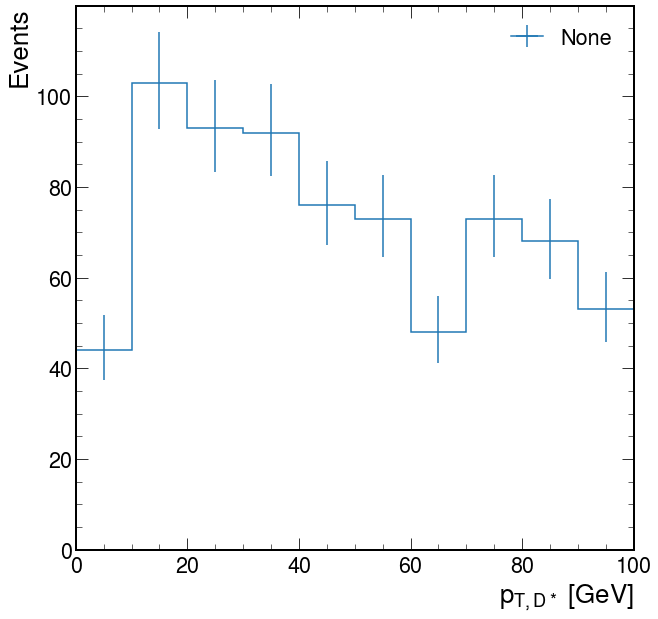

In [7]:
hist_reco_pt = output['Dstar_reco_pt']
hist_gen_pt = output['Dstar_gen_pt']
hist.plot1d(hist_reco_pt)

In [8]:
def build_4mom_string(candidate):
    return f'({candidate.pt:.2f},{candidate.eta:.2f},{candidate.phi:.2f},{candidate.mass:.2f})'

def to_cartesian(cand):
    x = cand.pt*math.cos(cand.phi)
    y = cand.pt*math.sin(cand.phi)
    z = cand.pt*math.sinh(cand.eta)
    t = math.sqrt(x*x + y*y + z*z + cand.mass*cand.mass)

    return t, x, y, z

def sum_cand(cand1, cand2):
    t1, x1, y1, z1 = to_cartesian(cand1)
    t2, x2, y2, z2 = to_cartesian(cand2)

    tr = t1+t2
    xr = x1+x2
    yr = y1+y2
    zr = z1+z2

    r = math.sqrt(xr*xr + yr*yr + zr*zr)
    pt = math.sqrt(xr*xr + yr*yr)
    eta = math.asinh(zr / r)
    phi = math.atan2(yr, xr)
    mass = math.sqrt(tr*tr - xr*xr - yr*yr - zr*zr)

    return f'({pt:.2f},{eta:.2f},{phi:.2f},{mass:.2f})'


def print_candidate(candidate):
    quadrimom = build_4mom_string(candidate)
    print(f"PDGId: {candidate.pdgId}, motherId: {candidate.genPartIdxMother}, n_daughters: {candidate.numberOfDaughters}, status: {candidate.status}, 4-momentum (pt, eta, phi, mass): {quadrimom}, vertex: ({candidate.vx:.2f},{candidate.vy:.2f},{candidate.vz:.2f})")

In [9]:
import uproot

In [10]:
f = uproot.open(files[0])
events = f['Events'].arrays()

GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMLorentzVector")
        
# Muon
GenPart_Muon = GenPart[(np.absolute(GenPart.pdgId) == 13) & (GenPart.genPartIdxMother > -1)]
GenPart_Muon = ak.combinations(GenPart_Muon, 2)
GenPart_Muon = GenPart_Muon[GenPart_Muon.slot0.genPartIdxMother == GenPart_Muon.slot1.genPartIdxMother]
leading_mu = (GenPart_Muon.slot0.pt > GenPart_Muon.slot1.pt)
GenPart_Muon_lead = ak.where(leading_mu, GenPart_Muon.slot0, GenPart_Muon.slot1)
GenPart_Muon_trail = ak.where(~leading_mu, GenPart_Muon.slot0, GenPart_Muon.slot1)

# Jpsi
GenPart_Jpsi = GenPart[GenPart.pdgId == 443]

# Dstar
GenPart_Dstar = GenPart[np.abs(GenPart.pdgId == 413)]

Dimu = ak.zip({**get_vars_dict(events, dimu_cols)}, with_name="PtEtaPhiMCandidate")
Muon = ak.zip({**get_vars_dict(events, muon_cols)}, with_name="PtEtaPhiMCandidate")
Dstars = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
#Muon = ak.zip({'0': Muon[Dimu.t1muIdx], '1': Muon[Dimu.t2muIdx]})

for i0 in range(len(GenPart_Dstar)):
    print(i0)
    print('GenParticles')
    for i1 in range(len(GenPart_Dstar[i0])):
        print_candidate(GenPart_Dstar[i0][i1])
        print('\t', end='')
        print_candidate(GenPart_Muon_lead[i0][i1])
        print('\t', end='')
        print_candidate(GenPart_Muon_trail[i0][i1])
        print(f'Mom 4-momentum: {build_4mom_string(GenPart_Muon_trail[i0][i1]+GenPart_Muon_lead[i0][i1])}')
        print('')
    print('Reco')
    for i1 in range(len(Dimu[i0])):
        print(f'Dimu: {build_4mom_string(Dimu[i0][i1])}')
    '''for i1 in range(len(Muon.slot0[i0])):
        print('\t', end='')
        print(f'Muon 0: {build_4mom_string(Muon.slot0[i0][i1])}')
        print('\t', end='')
        print(f'Muon 1: {build_4mom_string(Muon.slot1[i0][i1])}')'''
    #for i1 in range(len(Muon[i0])):
        #print('\t', end='')
        #print(f'Muon: {build_4mom_string(Muon[i0][i1])}, charge: {Muon.charge[i0][i1]}, vertex: ({Muon[i0][i1].x:.2f},{Muon[i0][i1].y:.2f},{Muon[i0][i1].z:.2f})')

0
GenParticles
PDGId: 413, motherId: -999, n_daughters: 2, status: 2, 4-momentum (pt, eta, phi, mass): (88.69,1.06,-1.09,2.01), vertex: (-0.03,0.07,-8.18)
	

ValueError: in IndexedArray64 attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.7.0/src/libawkward/array/IndexedArray.cpp#L1259)

In [94]:
Dimu[ak.num(Dimu) >0].pt

<Array [[94.1], [99.9], ... [94.9], [42.4]] type='16 * var * float32'>

In [ ]:
#################################### Old ####################################

In [21]:
from coffea.util import load
import uproot3
from ROOT import TFile, TH2D, TChain, TCanvas, TLatex

Welcome to JupyROOT 6.24/02


In [22]:
# Load coffea file
file = '../output/jpsi_gun/jpsi_gun_hists.coffea'
acc = load(file)

In [23]:
# Take gen dstar pt and eta
gen_dstar_pt = acc['Gen_Dstar']['pt'].value
gen_dstar_eta = acc['Gen_Dstar']['eta'].value
# Take rec dstar pt and eta 
rec_dstar_pt = acc['Dstar']['pt'].value[~acc['Dstar']['wrg_chg'].value]
rec_dstar_eta = acc['Dstar']['eta'].value[~acc['Dstar']['wrg_chg'].value]

with uproot3.recreate("ex.root") as f:
        f['gen_dstar'] = uproot3.newtree({"gen_dstar_pt": "float64",  "gen_dstar_eta" : "float64"})
        f['gen_dstar'].extend({"gen_dstar_pt": gen_dstar_pt, "gen_dstar_eta" : gen_dstar_eta})

        f['rec_dstar'] = uproot3.newtree({"rec_dstar_pt": "float64",  "rec_dstar_eta" : "float64"})
        f['rec_dstar'].extend({"rec_dstar_pt": rec_dstar_pt, "rec_dstar_eta" : rec_dstar_eta})

KeyError: 'Gen_Dstar'

In [ ]:
def create_ttree(file, root_file):
    # Load coffea file
    acc = load(file)
    # Take gen Jpsi pt and eta
    gen_jpsi_pt = acc['Gen_Jpsi']['pt'].value
    gen_jpsi_eta = acc['Gen_Jpsi']['eta'].value
    # Take rec Jpsi pt and eta
    rec_jpsi_pt = acc['Dimu']['pt'].value[acc['Dimu']['is_jpsi'].value]
    rec_jpsi_eta = acc['Dimu']['eta'].value[acc['Dimu']['is_jpsi'].value]
    
    # Use uproot t
    with uproot3.recreate(root_file) as f:
        f['gen_jpsi'] = uproot3.newtree({"gen_jpsi_pt": "float64",  "gen_jpsi_eta" : "float64"})
        f['gen_jpsi'].extend({"gen_jpsi_pt": gen_jpsi_pt, "gen_jpsi_eta" : gen_jpsi_eta})

        f['rec_jpsi'] = uproot3.newtree({"rec_jpsi_pt": "float64",  "rec_jpsi_eta" : "float64"})
        f['rec_jpsi'].extend({"rec_jpsi_pt": rec_jpsi_pt, "rec_jpsi_eta" : rec_jpsi_eta})

In [ ]:
# Calls the function to create root file with the data
file = '../output/jpsi_gun/jpsi_gun.coffea'
root_file = "jpsi_acceptance.root"
create_ttree(file, root_file)

In [ ]:
file_root = TFile.Open("jpsi_acceptance.root")

In [ ]:
def acceptance(root_file):
       
    ## Rec Jpsi
    
    # Creates chain to open the file
    chain_rec = TChain("rec_jpsi")
    chain_rec.Add(root_file)
    
    # Takes pt and eta
    rec_jpsi_pt = chain_rec.AsMatrix(["rec_jpsi_pt"])
    rec_jpsi_eta = chain_rec.AsMatrix(["rec_jpsi_eta"])
    
    # Creates 2D histogram 
    rec_hist = TH2D('rec', '; ;; ', 50, 0, 40, 50, -2.5, 2.5,)
    rec_hist.SetStats(False)
    
    # Draw
    chain_rec.Draw("rec_jpsi_eta:rec_jpsi_pt>>rec")
    
    ## Gen Jpsi
    
    # Creates chain to open the file
    
    chain_gen = TChain("gen_jpsi")
    chain_gen.Add(root_file)
    
    # Takes pt and eta
    gen_jpsi_pt = chain_gen.AsMatrix(["gen_jpsi_pt"])
    gen_jpsi_eta = chain_gen.AsMatrix(["gen_jpsi_eta"])

    # Creates 2D histogram
    gen_hist = TH2D('gen', '; ;; ', 50, 0, 40, 50, -2.5, 2.5)
    gen_hist.SetStats(False)
    

    chain_gen.Draw("gen_jpsi_eta:gen_jpsi_pt>>gen")

    can = TCanvas("can", "histograms", 850, 650)

    can.Draw()
    
    gen_hist.Draw("colz")
    
    can = TCanvas("can", "histograms", 850, 650)
    rec_hist_clone = rec_hist
    rec_hist_clone.Divide(gen_hist)
    can.Draw()
    rec_hist_clone.SetStats(False)
    rec_hist_clone.Draw("colz")
    
    ## Axis
    
    # x axis - pT
    pt_ax = TLatex()
    pt_ax.SetNDC()
    pt_ax.SetTextFont(43)
    pt_ax.SetTextSize(20)
    pt_ax.DrawLatex(.8, 0.03, "J/#Psi p_{T} (GeV/c)")
    
    # y axis - eta
    eta_ax = TLatex()
    eta_ax.SetNDC()
    eta_ax.SetTextFont(43)
    eta_ax.SetTextSize(20)
    eta_ax.SetTextAngle(90)
    eta_ax.DrawLatex(0.05, 0.65, "J/#Psi pseudorapidity")
    
    can.SaveAs("ex.png")

In [ ]:
root_file = "jpsi_acceptance.root"
acceptance(root_file)

In [ ]:
################################### Tests ###################################

############## Dstar

# Load coffea file
file = '../output/Monte_Carlo_2017/Monte_Carlo_2017.coffea'
acc = load(file)
# Take gen dstar pt and eta
gen_dstar_pt = acc['Gen_Dstar']['pt'].value
gen_dstar_eta = acc['Gen_Dstar']['eta'].value
# Take rec dstar pt and eta 
rec_dstar_pt = acc['Dstar']['pt'].value[~acc['Dstar']['wrg_chg'].value]
rec_dstar_eta = acc['Dstar']['eta'].value[~acc['Dstar']['wrg_chg'].value]

with uproot3.recreate("ex.root") as f:
        f['gen_dstar'] = uproot3.newtree({"gen_dstar_pt": "float64",  "gen_dstar_eta" : "float64"})
        f['gen_dstar'].extend({"gen_dstar_pt": gen_dstar_pt, "gen_dstar_eta" : gen_dstar_eta})

        f['rec_dstar'] = uproot3.newtree({"rec_dstar_pt": "float64",  "rec_dstar_eta" : "float64"})
        f['rec_dstar'].extend({"rec_dstar_pt": rec_dstar_pt, "rec_dstar_eta" : rec_dstar_eta})

In [ ]:
chain_rec = TChain("rec_jpsi")
chain_rec.Add("jpsi_acceptance.root")

rec_jpsi_pt = chain_rec.AsMatrix(["rec_jpsi_pt"])
rec_jpsi_eta = chain_rec.AsMatrix(["rec_jpsi_eta"])

rec_hist = TH2D('rec', '; ;; ', 50, 0, 60, 50, -2.5, 2.5)

chain_rec.Draw("rec_jpsi_eta:rec_jpsi_pt>>rec")

can1 = TCanvas("c1", "histograms", 850, 650)

can1.Draw()
rec_hist.SetStats(False)
rec_hist.Draw("colz")
can1.SaveAs("Rec_Jpsi.png")

In [ ]:
chain_gen = TChain("gen_jpsi")
chain_gen.Add("jpsi_acceptance.root")

gen_jpsi_pt = chain_gen.AsMatrix(["gen_jpsi_pt"])
gen_jpsi_eta = chain_gen.AsMatrix(["gen_jpsi_eta"])

gen_hist = TH2D('gen', '$ gen $; ;; ', 50, 0, 60, 50, -2.5, 2.5)

chain_gen.Draw("gen_jpsi_eta:gen_jpsi_pt>>gen")

can2 = TCanvas("can2", "histograms", 850, 650)

can2.Draw()
gen_hist.SetStats(False)
gen_hist.Draw("colz")
can2.SaveAs("Gen_Jpsi.png")

In [ ]:
from coffea.util import load
import numpy as np
from coffea import processor, hist

import mplhep
import matplotlib.pyplot as plt
plt.style.use(mplhep.style.CMS)

In [ ]:
def ratio_plot(hist_reco, hist_gen):
    fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
    }
    error_opts_1 = {
        'facecolor': 'none',
        'edgecolor': (0,0,0,.5),
        'linewidth': 0
    }
    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }
    
    error_opts_2 = {
        'facecolor': 'none',
        'linewidth': 0,
    }
    
    fig, (ax, rax) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,10),
    gridspec_kw={"height_ratios": (3, 1)},
    sharex=True
    )
    fig.subplots_adjust(hspace=.07)
    
    # plot the MC first
    hist.plot1d(
        hist_gen,
        ax=ax,
        clear=False,
        stack=False,
        line_opts=None,
        fill_opts=fill_opts,
        error_opts=error_opts_1
    )
    hist.plot1d(
        hist_reco,
        ax=ax,
        clear=False,
        stack=False,
        line_opts=None,
        fill_opts=fill_opts,
        error_opts=error_opts_2
    )
    
    ax.autoscale(axis='x', tight=True)
    ax.set_xlabel("")
    leg = ax.legend()
    
    hist.plotratio(
    num=hist_reco,
    denom=hist_gen,
    ax=rax,
    error_opts=data_err_opts,
    denom_fill_opts={},
    guide_opts={},
    unc='num'
    )
    rax.set_ylabel('Ratio')
    rax.set_ylim(0,2)
    
    ax.set_xlim(0,30)
    
    return ax, rax

In [ ]:
def create_plot1d(hist1d, log=False, density=False, ax=None):
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea
    plt.style.use(mplhep.style.CMS)
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })
    fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
    }
    
    ax = hist.plot1d(hist1d, ax=ax, fill_opts=fill_opts, density=density)
    
    if log:
        ax.set_yscale('log')
        ax.set_ylim(1, None)
    else:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,3), useMathText=True)
    
    axis = hist1d.axes()[0]
    centers = axis.centers()
    values = np.where(hist1d.values().get(()) < 0, 0, hist1d.values().get(()))
    
    # compute mean and std:
    mean = np.sum(values*centers)/np.sum(values)
    std = np.sqrt(np.sum(values*((centers - mean)**2))/np.sum(values))
    
    annotation = TextArea(f"Total: {np.sum(values):.2e}" \
                    + "\n" + f"Mean: {mean:.2e}" \
                    + "\n" + f"Std: {std:.2e}", textprops=dict(size=14))
    
    at = AnchoredOffsetbox('upper right', child=annotation)
    at.patch.set_facecolor('None')
    #ax.add_artist(at)
    
    ax.legend().remove()
    
    return ax

In [ ]:
hist_path = file = '../output/jpsi_gun/jpsi_gun_hists.coffea'
hists = load(hist_path)

In [ ]:
hist_reco_pt = hists['Jpsi_p'].sum('eta', 'phi')
hist_gen_pt = hists['GenJpsi_p'].sum('eta', 'phi')

In [ ]:
ratio_plot(hist_reco_pt, hist_gen_pt)

In [ ]:
hist_reco_eta = hists['Jpsi_p'].sum('pt', 'phi')
hist_gen_eta = hists['GenJpsi_p'].sum('pt', 'phi')

In [ ]:
ratio_plot(hist_reco_eta, hist_gen_eta)

In [ ]:
def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output

        output['details']['n_events'] += len(events)
        
        # Collection extraction
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        # Gen_Ds
        GenPart_D0 = GenPart[np.absolute(GenPart.pdgId) == 421]
        GenPart_Dstar = GenPart[np.absolute(GenPart.pdgId) == 413]

        # Save N of objs
        output['details']['n_Gen_Dstar'] += ak.sum(ak.num(GenPart_Dstar))
        output['details']['n_Gen_D0'] += ak.sum(ak.num(GenPart_D0))

        # Create histos
        self.hists['Gen_Dstar']['Gen_Dstar_pt'].fill(pt=ak.flatten(GenPart_Dstar.pt))
        self.hists['Gen_Dstar']['Gen_Dstar_eta'].fill(eta=ak.flatten(GenPart_Dstar.eta))
        self.hists['Gen_Dstar']['Gen_Dstar_phi'].fill(phi=ak.flatten(GenPart_Dstar.phi))
        self.hists['Gen_Dstar']['Gen_Dstar_deltam'].fill(deltam=ak.flatten(GenPart_Dstar.mass - D0_PDG_MASS))
        self.hists['Gen_Dstar']['Gen_Dstar_ptxeta'].fill(
            pt=ak.flatten(GenPart_Dstar.pt),
            eta=ak.flatten(GenPart_Dstar.eta)
            )

        self.hists['Gen_D0']['Gen_D0_pt'].fill(pt=ak.flatten(GenPart_D0.pt))
        self.hists['Gen_D0']['Gen_D0_eta'].fill(eta=ak.flatten(GenPart_D0.eta))
        self.hists['Gen_D0']['Gen_D0_phi'].fill(phi=ak.flatten(GenPart_D0.phi))
        self.hists['Gen_D0']['Gen_D0_mass'].fill(mass=ak.flatten(GenPart_D0.mass))
        self.hists['Gen_D0']['Gen_D0_ptxeta'].fill(
            pt=ak.flatten(GenPart_D0.pt),
            eta=ak.flatten(GenPart_D0.eta)
            )

        D0 = ak.zip({'mass': events.D0_mass12, **get_vars_dict(events, d0_cols)}, with_name="PtEtaPhiMCandidate")
        closer_mass = np.absolute(D0.mass12 - D0_PDG_MASS) < np.absolute(D0.mass21 - D0_PDG_MASS)
        D0['mass'] = ak.where(closer_mass, D0.mass12, D0.mass21)
        D0 = D0[~D0.hasMuon]

        D0 = D0[(D0.mass > 1.8) & (D0.mass < 1.94)]
        Dstar = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
        Dstar = Dstar[~(Dstar.Kchg == Dstar.pichg)]
        Dstar = Dstar[~Dstar.hasMuon]
        Dstar = Dstar[(Dstar.deltamr > 0.14) & (Dstar.deltamr < 0.15)]

        self.hists['Reco_Dstar']['Reco_Dstar_pt'].fill(pt=ak.flatten(Dstar.pt))
        self.hists['Reco_Dstar']['Reco_Dstar_eta'].fill(eta=ak.flatten(Dstar.eta))
        self.hists['Reco_Dstar']['Reco_Dstar_phi'].fill(phi=ak.flatten(Dstar.phi))
        self.hists['Reco_Dstar']['Reco_Dstar_deltam'].fill(deltam=ak.flatten(Dstar.deltamr))
        self.hists['Reco_Dstar']['Reco_Dstar_ptxeta'].fill(
            pt=ak.flatten(Dstar.pt),
            eta=ak.flatten(Dstar.eta)
            )

        self.hists['Reco_D0']['Reco_D0_pt'].fill(pt=ak.flatten(D0.pt))
        self.hists['Reco_D0']['Reco_D0_eta'].fill(eta=ak.flatten(D0.eta))
        self.hists['Reco_D0']['Reco_D0_phi'].fill(phi=ak.flatten(D0.phi))
        self.hists['Reco_D0']['Reco_D0_mass'].fill(mass=ak.flatten(D0.mass))
        self.hists['Reco_D0']['Reco_D0_ptxeta'].fill(
            pt=ak.flatten(D0.pt),
            eta=ak.flatten(D0.eta)
            )

        output['details']['n_Reco_Dstar'] += ak.sum(ak.num(Dstar))
        output['details']['n_Reco_D0'] += ak.sum(ak.num(D0))

        return self.hists

In [ ]:
data = {"test": files[:50]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=AcceptTestProcessor(),
                                    executor=processor.iterative_executor, #iterative, futures
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

print(f"Process finished in: {time.time() - tstart:.2f} s")

In [30]:
######################################## TEst do FAT MAPSE ########################################

In [14]:
import time
import math, os

from coffea.nanoevents import BaseSchema

import awkward as ak
import numpy as np
from coffea import processor

from hist import Hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import matplotlib.pyplot as plt

In [17]:
class AcceptanceProcessor(processor.ProcessorABC):
    def _init_(self):
        Gen_Dstar_hists = {
            'Gen_Dstar_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]").Double(),
            'Gen_Dstar_eta': Hist.new.Regular(60, -4, 4, name="eta", label=r"$\eta_{D^* Gen}$").Double(),
            'Gen_Dstar_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{D^* Gen}$").Double(),
            'Gen_Dstar_deltam': Hist.new.Regular(50, 0.138, 0.162, name="deltam", label=r"$\Delta m_{D^* Gen}$ [GeV]").Double(),
            'Gen_Dstar_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{D^* Gen}$")
                .Double()
                ),
        }

        Gen_D0_hists = {
            'Gen_D0_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,D_0 Gen}$ [GeV]").Double(),
            'Gen_D0_eta': Hist.new.Regular(60, -5, 5, name="eta", label=r"$\eta_{D_0 Gen}$").Double(),
            'Gen_D0_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{D_0 Gen}$").Double(),
            'Gen_D0_mass': Hist.new.Regular(100, 1.7, 2.0, name="mass", label=r"$m_{D_0 Gen}$ [GeV]").Double(),
            'Gen_D0_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,D_0 Gen}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{D_0 Gen}$")
                .Double()
                ),
        }

        Reco_Dstar_hists = {
            'Reco_Dstar_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,D^* Reco}$ [GeV]").Double(),
            'Reco_Dstar_eta': Hist.new.Regular(60, -4, 4, name="eta", label=r"$\eta_{D^* Reco}$").Double(),
            'Reco_Dstar_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{D^* Reco}$").Double(),
            'Reco_Dstar_deltam': Hist.new.Regular(50, 0.138, 0.162, name="deltam", label=r"$\Delta m_{D^* Reco}$ [GeV]").Double(),
            'Reco_Dstar_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,D^* Reco}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{D^* Reco}$")
                .Double()
                ),
        }

        Reco_D0_hists = {
            'Reco_D0_pt': Hist.new.Regular(100, 0, 100, name='pt', label=r"$p_{T,D_0 Reco}$ [GeV]").Double(),
            'Reco_D0_eta': Hist.new.Regular(60, -5, 5, name="eta", label=r"$\eta_{D_0 Reco}$").Double(),
            'Reco_D0_phi': Hist.new.Regular(60, -math.pi, math.pi, name="phi", label=r"$\phi_{D_0 Reco}$").Double(),
            'Reco_D0_mass': Hist.new.Regular(100, 1.7, 2.0, name="mass", label=r"$m_{D_0 Reco}$ [GeV]").Double(),
            'Reco_D0_ptxeta': (
                Hist.new
                .Regular(10, 0, 100, name='pt', label=r"$p_{T,D_0 Reco}$ [GeV]")
                .Regular(10, -4, 4, name="eta", label=r"$\eta_{D_0 Reco}$")
                .Double()
                ),
        }
        
        self._hists = {
            'Gen_Dstar': {**Gen_Dstar_hists},
            'Gen_D0': {**Gen_D0_hists},
            'Reco_Dstar': {**Reco_Dstar_hists},
            'Reco_D0': {**Reco_D0_hists},
        }


    @property
    def hists(self):
        return self._hists

    def process(self, events):

        
        # test if there is any events in the file
        if len(events) == 0:
            return output

        output['details']['n_events'] += len(events)
        
        # Collection extraction
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        # Gen_Ds
        GenPart_D0 = GenPart[np.absolute(GenPart.pdgId) == 421]
        GenPart_Dstar = GenPart[np.absolute(GenPart.pdgId) == 413]

        # Save N of objs
        output['details']['n_Gen_Dstar'] += ak.sum(ak.num(GenPart_Dstar))
        output['details']['n_Gen_D0'] += ak.sum(ak.num(GenPart_D0))

        # Create histos
        self.hists['Gen_Dstar']['Gen_Dstar_pt'].fill(pt=ak.flatten(GenPart_Dstar.pt))
        self.hists['Gen_Dstar']['Gen_Dstar_eta'].fill(eta=ak.flatten(GenPart_Dstar.eta))
        self.hists['Gen_Dstar']['Gen_Dstar_phi'].fill(phi=ak.flatten(GenPart_Dstar.phi))
        self.hists['Gen_Dstar']['Gen_Dstar_deltam'].fill(deltam=ak.flatten(GenPart_Dstar.mass - D0_PDG_MASS))
        self.hists['Gen_Dstar']['Gen_Dstar_ptxeta'].fill(
            pt=ak.flatten(GenPart_Dstar.pt),
            eta=ak.flatten(GenPart_Dstar.eta)
            )

        self.hists['Gen_D0']['Gen_D0_pt'].fill(pt=ak.flatten(GenPart_D0.pt))
        self.hists['Gen_D0']['Gen_D0_eta'].fill(eta=ak.flatten(GenPart_D0.eta))
        self.hists['Gen_D0']['Gen_D0_phi'].fill(phi=ak.flatten(GenPart_D0.phi))
        self.hists['Gen_D0']['Gen_D0_mass'].fill(mass=ak.flatten(GenPart_D0.mass))
        self.hists['Gen_D0']['Gen_D0_ptxeta'].fill(
            pt=ak.flatten(GenPart_D0.pt),
            eta=ak.flatten(GenPart_D0.eta)
            )

        D0 = ak.zip({'mass': events.D0_mass12, **get_vars_dict(events, d0_cols)}, with_name="PtEtaPhiMCandidate")
        closer_mass = np.absolute(D0.mass12 - D0_PDG_MASS) < np.absolute(D0.mass21 - D0_PDG_MASS)
        D0['mass'] = ak.where(closer_mass, D0.mass12, D0.mass21)
        D0 = D0[~D0.hasMuon]

        D0 = D0[(D0.mass > 1.8) & (D0.mass < 1.94)]
        Dstar = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
        Dstar = Dstar[~(Dstar.Kchg == Dstar.pichg)]
        Dstar = Dstar[~Dstar.hasMuon]
        Dstar = Dstar[(Dstar.deltamr > 0.14) & (Dstar.deltamr < 0.15)]

        self.hists['Reco_Dstar']['Reco_Dstar_pt'].fill(pt=ak.flatten(Dstar.pt))
        self.hists['Reco_Dstar']['Reco_Dstar_eta'].fill(eta=ak.flatten(Dstar.eta))
        self.hists['Reco_Dstar']['Reco_Dstar_phi'].fill(phi=ak.flatten(Dstar.phi))
        self.hists['Reco_Dstar']['Reco_Dstar_deltam'].fill(deltam=ak.flatten(Dstar.deltamr))
        self.hists['Reco_Dstar']['Reco_Dstar_ptxeta'].fill(
            pt=ak.flatten(Dstar.pt),
            eta=ak.flatten(Dstar.eta)
            )

        self.hists['Reco_D0']['Reco_D0_pt'].fill(pt=ak.flatten(D0.pt))
        self.hists['Reco_D0']['Reco_D0_eta'].fill(eta=ak.flatten(D0.eta))
        self.hists['Reco_D0']['Reco_D0_phi'].fill(phi=ak.flatten(D0.phi))
        self.hists['Reco_D0']['Reco_D0_mass'].fill(mass=ak.flatten(D0.mass))
        self.hists['Reco_D0']['Reco_D0_ptxeta'].fill(
            pt=ak.flatten(D0.pt),
            eta=ak.flatten(D0.eta)
            )

        output['details']['n_Reco_Dstar'] += ak.sum(ak.num(Dstar))
        output['details']['n_Reco_D0'] += ak.sum(ak.num(D0))

        return self.hists

    def postprocess(self, accumulator):
        return accumulator

In [18]:
""" data = {"test": ["/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonToMuMuDstarToD0pi/211111_200135/0000/UpsilonToMuMuDstarToD0pi_688.root",
                 "/eos/user/k/kmotaama/CRAB_UserFiles/UpsilonToMuMuDstarToD0pi/211111_200135/0000/UpsilonToMuMuDstarToD0pi_689.root"]} """
#files = ['/afs/cern.ch/work/k/kmotaama/public/analysis/OniaOpenCharmRun2UL/OniaOpenCharmRun2ULMC/CMSSW_10_6_12/src/genTuple/genTuple/test.root']
data = {"test": files[0:1]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=AcceptanceProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

""" hists = output[1]
output = output[0] """

print(f"Process finished in: {time.time() - tstart:.2f} s")
#print(output[0]['details'])

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

AttributeError: 'AcceptanceProcessor' object has no attribute '_hists'

Failed processing file: /eos/user/k/kmotaama/CRAB_UserFiles/DstarPtGun/220110_124229/0000/DstarPtGun_1.root (0-100)